In [1]:
import time
import pandas as pd
import torch
import matplotlib.pyplot as plt

from foqal.utils.io import IO
from foqal.causal.classical import ClassicalCommonCause, Superdeterminism, Superluminal
from foqal.causal.quantum import QuantumCommonCause
from foqal.fit import fit

In [2]:
print(f"CUDA is available: {torch.cuda.is_available()}")
device = "cpu"
verbose = True

io = IO.directory(
    folder="entangled-state-data", include_date=False, include_id=False, verbose=False,
)
m = 40
p = 0.0
latent_dim = 100
lr = 0.25
n_steps = 300

CUDA is available: True


In [3]:
train_data = torch.Tensor(io.load_np_array(filename=f"m={m}_p={p}_run{0}.npy")).to(device)
test_data = torch.Tensor(io.load_np_array(filename=f"m={m}_p={p}_run{1}.npy")).to(device)

In [5]:
df = []

for Model in [
    ClassicalCommonCause,
    Superdeterminism,
    Superluminal,
    QuantumCommonCause,
]:
    if Model is QuantumCommonCause:
        _latent_dim = 2
    else:
        _latent_dim = latent_dim

    model = Model(n_settings=m, latent_dim=_latent_dim)
    model = model.to(device)

    optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    loss = torch.nn.MSELoss()

    t0 = time.time()
    losses = fit(model, train_data, optimizer, loss, n_steps=n_steps, progress=True)
    t1 = time.time()

    if verbose:
        print(
            f"\n{model.__class__.__name__} | "
            f"\n\tTotal time: {t1 - t0}| "
            f"\n\tTotal parameters: {sum(p.numel() for p in model.parameters())}"
            f"\n\tFinal loss: {losses[-1]}"
        )

    torch.cuda.empty_cache()

    loss_test = loss(model.forward(), test_data)
    if loss_test.is_cuda:
        loss_test = loss_test.cpu().detach().numpy().item()
    else:
        loss_test = loss_test.detach().numpy().item()

    df.append(dict(
        model=model.__class__.__name__,
        m=m,
        p=p,
        latent_dim=_latent_dim,
        train_loss=losses[-1].item(),
        test_loss=loss_test,
        train_curve=losses,
        t=(t1 - t0),
        lr=lr,
        n_steps=n_steps,
    ))

io.verbose = True
# df = pd.DataFrame(df)
#
# io = IO.directory(
# folder=f"entangled-state-data-{m}", include_date=False, include_id=False, verbose=True,
# )
# io.save_dataframe(df, filename="summary_of_fitting.txt")

Cost: 0.0014467683: 100%|██████████| 300/300 [00:03<00:00, 76.14it/s]



ClassicalCommonCause | 
	Total time: 3.946956157684326| 
	Total parameters: 8100
	Final loss: 0.0014467682922258973


Cost: 0.0001201658: 100%|██████████| 300/300 [00:05<00:00, 55.38it/s]



Superdeterminism | 
	Total time: 5.422316312789917| 
	Total parameters: 12100
	Final loss: 0.00012016577966278419


Cost: 0.0000616547: 100%|██████████| 300/300 [00:05<00:00, 58.35it/s]



Superluminal | 
	Total time: 5.143952369689941| 
	Total parameters: 164100
	Final loss: 6.165472586872056e-05


Cost: 0.0001750926: 100%|██████████| 300/300 [00:03<00:00, 79.53it/s]


QuantumCommonCause | 
	Total time: 3.7752127647399902| 
	Total parameters: 340
	Final loss: 0.00017509258759673685


[{'model': 'ClassicalCommonCause',
  'm': 40,
  'p': 0.0,
  'latent_dim': 100,
  'train_loss': 0.0014467682922258973,
  'test_loss': 0.001461591455154121,
  'train_curve': [array(0.02157086, dtype=float32),
   array(0.02759052, dtype=float32),
   array(0.02098794, dtype=float32),
   array(0.01622952, dtype=float32),
   array(0.01177242, dtype=float32),
   array(0.00825666, dtype=float32),
   array(0.00586234, dtype=float32),
   array(0.00445904, dtype=float32),
   array(0.00377484, dtype=float32),
   array(0.00363309, dtype=float32),
   array(0.00362375, dtype=float32),
   array(0.00319052, dtype=float32),
   array(0.00266227, dtype=float32),
   array(0.00229189, dtype=float32),
   array(0.00211811, dtype=float32),
   array(0.00202762, dtype=float32),
   array(0.00196584, dtype=float32),
   array(0.00191742, dtype=float32),
   array(0.00187653, dtype=float32),
   array(0.00184156, dtype=float32),
   array(0.00181116, dtype=float32),
   array(0.00178413, dtype=float32),
   array(0.00176

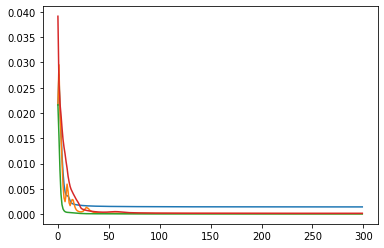

In [8]:
for i in range(4):
    plt.plot(df[i]['train_curve'])
df